# Analysis of the Human Connectome Project (funcional connectome)

## Imports

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#!pip install git+https://github.com/pni-lab/mlconfound --upgrade
#from importlib import reload
#reload(mlconfound.plot)
from mlconfound.stats import test_fully_confounded, test_partially_confounded
from mlconfound.plot import plot_graph

from mlxtend.evaluate import permutation_test

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols as ols_f
from scipy.stats import kurtosis, skew

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import quantile_transform

from neurocombat_sklearn import CombatModel

## Load data

In [2]:
# HCP data can be obtainedc from the connectomeDB with special license
# data is not part of this repository
subjectIDs = pd.read_csv('../data_in/hcp/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('../data_in/hcp/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('../data_in/hcp/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('../data_in/hcp/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,age
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80,23.5
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,28.0


### Select target variable

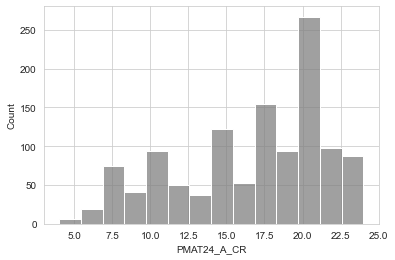

In [3]:
##########################################################
# change these
target = 'PMAT24_A_CR' # fluid intelligence
feature_data = netmats_parcor
##########################################################

sns.histplot(behavior[target], color='gray')
plt.savefig('../data_out/fig/hcp_iq_nonnorm_hist.pdf')

# it's a good practice to use pandas for merging, messing up subject order can be painful
features = feature_data.columns
df = behavior
df = df.merge(feature_data, left_index=True, right_index=True, how='left')
df = df.dropna(subset = [target] + features.values.tolist())
y = df[target].values
X = df[features].values

### Normalize target

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (999). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


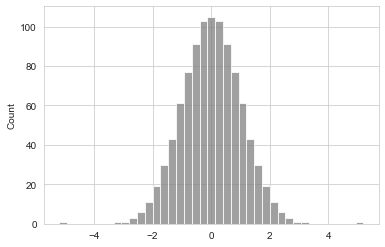

In [4]:
rng = np.random.default_rng(42)
y_trf = quantile_transform(np.array([y+rng.uniform(0,1,len(y))-0.5]).T, output_distribution='normal', n_quantiles=1000).flatten()

sns.histplot(y_trf, color='gray')
plt.savefig('../data_out/fig/hcp_iq_quanttrf_hist.pdf')

kurtosis(y_trf), skew(y_trf)
y=y_trf


# Machine Learning on raw data

In [5]:
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', Ridge(max_iter=100000))])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__alpha': [0.000001, 0.01, 0.1, 1, 10, 100, 1000000]}


In [6]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.2s finished


cv: 0 {'model__alpha': 100000} -0.9199305094605637 -0.9786879290498206
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.6s finished


cv: 1 {'model__alpha': 100000} -0.9077079825659722 -1.0804186751948508
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.5s finished


cv: 2 {'model__alpha': 100000} -0.9331575065292261 -0.8310754278190692
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.1s finished


cv: 3 {'model__alpha': 10000} -0.8975912683493059 -1.174726254503374
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.8s finished


cv: 4 {'model__alpha': 100000} -0.9269205642606619 -0.8765023704008671
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.1s finished


cv: 5 {'model__alpha': 100000} -0.9564344119011114 -0.6325980055959741
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   20.5s finished


cv: 6 {'model__alpha': 10000} -0.9092064303417263 -1.0547858952767653
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.5s finished


cv: 7 {'model__alpha': 100000} -0.9124024410173405 -0.9995504450415025
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.3s finished


cv: 8 {'model__alpha': 100000} -0.9055768764204952 -1.0469549239717029
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   25.3s finished


cv: 9 {'model__alpha': 100000} -0.9442157525601788 -0.7378036764381594


### Results (raw data)

*** Score on mean as model:	-1.0401469064852689
** Mean score in the inner crossvaludation (inner_cv):	-0.9213143743406583
** Mean Nested Crossvalidation Score (outer_cv):	-0.9413103603292086
Explained Variance: 0.09502171812444848
Correlation: 0.3079467831852805


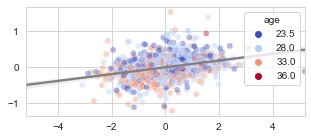

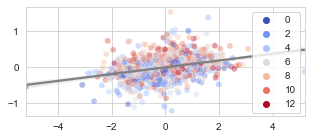

In [7]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.age, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_age_raw_regplot.pdf')
plt.show()

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_acq_raw_regplot.pdf')


## Confound testing: age groups (raw)

Permuting: 100%|██████████| 1000/1000 [00:07<00:00, 139.98it/s]


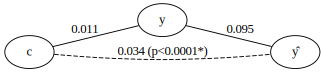

In [8]:
plot_graph(test_partially_confounded(y, predicted, df['age'],
                                     random_state=42), outfile_base='../data_out/fig/hcp_age_raw_partial')

Permuting: 100%|██████████| 1000/1000 [00:06<00:00, 165.77it/s]


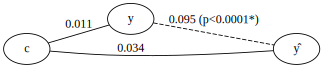

In [9]:
plot_graph(test_fully_confounded(y, predicted, df['age'],
                                random_state=42), outfile_base='../data_out/fig/hcp_age_raw_full')

## Confound testing: acquisition batch (raw)

Permuting: 100%|██████████| 1000/1000 [00:13<00:00, 71.66it/s]


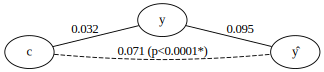

In [10]:
plot_graph(test_partially_confounded(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                     random_state=42), outfile_base='../data_out/fig/hcp_acq_raw_partial')

Permuting: 100%|██████████| 1000/1000 [00:05<00:00, 190.90it/s]


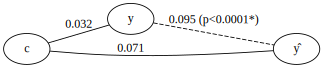

In [11]:
plot_graph(test_fully_confounded(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                random_state=42), outfile_base='../data_out/fig/hcp_acq_raw_full')

# Regress out confounder from features

In [12]:
# regress-out age from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    OLS_model = OLS(X[:,i], sm.add_constant(df.age)).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

In [14]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_adj, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.4s finished


cv: 0 {'model__alpha': 100000} -0.9334220737080547 -0.9811146700052951
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.2s finished


cv: 1 {'model__alpha': 100000} -0.9164853367721306 -1.1099518410820723
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.9s finished


cv: 2 {'model__alpha': 100000} -0.9439321286581528 -0.854095948403511
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.6s finished


cv: 3 {'model__alpha': 100000} -0.9123236661278249 -1.0922400329908144
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.0s finished


cv: 4 {'model__alpha': 100000} -0.9390295786046533 -0.8905698927275322
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.7s finished


cv: 5 {'model__alpha': 100000} -0.9695798813229786 -0.631716581035054
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.2s finished


cv: 6 {'model__alpha': 100000} -0.9254465278088265 -0.9626033785574833
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.4s finished


cv: 7 {'model__alpha': 100000} -0.9197005388218544 -1.0352285079959591
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.4s finished


cv: 8 {'model__alpha': 100000} -0.9192509336188476 -1.0424941380667336
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.7s finished


cv: 9 {'model__alpha': 100000} -0.9546094645041631 -0.7551569193538636


## Results (feature regression)

*** Score on mean as model:	-1.0401469064852689
** Mean score in the inner crossvaludation (inner_cv):	-0.9333780129947487
** Mean Nested Crossvalidation Score (outer_cv):	-0.9355171910218318
Explained Variance: 0.10059128649143256
Correlation: 0.33706125246136154


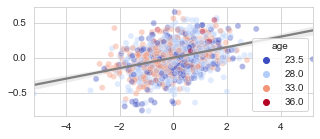

In [15]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.age, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_age_reg_regplot.pdf')

#### Confound test (feature regression)

Permuting: 100%|██████████| 1000/1000 [00:04<00:00, 204.70it/s]


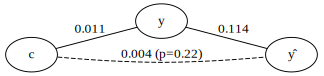

In [16]:
plot_graph(test_partially_confounded(y, predicted, df['age'], random_state=42),
          outfile_base='../data_out/fig/hcp_age_reg_partial')

Permuting: 100%|██████████| 1000/1000 [00:04<00:00, 234.54it/s]


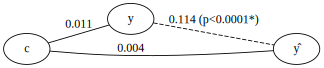

In [17]:
plot_graph(test_fully_confounded(y, predicted, df['age'], random_state=42),
           outfile_base='../data_out/fig/hcp_age_reg_full')

## Regress out acquisition batch

In [18]:
# regress-out acquisition from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    tmp = pd.DataFrame({
        'x': df.Acquisition.values,
        'y': X[:,i]
    })
    OLS_model = ols_f("y ~ C(x)", tmp).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

In [32]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_adj, y):

    
    
    clf.fit(X_adj[train], y[train])
    
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.3s finished


cv: 0 {'model__alpha': 100000} -0.9429954500606232 -0.9938514974116522
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.9s finished


cv: 1 {'model__alpha': 100000} -0.9270634172055751 -1.1134098122012304
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.8s finished


cv: 2 {'model__alpha': 100000} -0.9558286017680448 -0.8450958622501165
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.4s finished


cv: 3 {'model__alpha': 100000} -0.9226426216611758 -1.093770130471228
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.0s finished


cv: 4 {'model__alpha': 100000} -0.9425643730189174 -0.9280262148347258
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.5s finished


cv: 5 {'model__alpha': 100000} -0.9788667555864009 -0.6454127140647614
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.1s finished


cv: 6 {'model__alpha': 100000} -0.9369325275522113 -0.9593783445730698
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.7s finished


cv: 7 {'model__alpha': 100000} -0.9289767950601743 -1.0438060919689722
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.3s finished


cv: 8 {'model__alpha': 100000} -0.9337688796561752 -1.0173978610463479
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.6s finished


cv: 9 {'model__alpha': 100000} -0.9592128234127069 -0.789766623721303


## Results (acquisition batch regressed out)

*** Score on mean as model:	-1.0401469064852689
** Mean score in the inner crossvaludation (inner_cv):	-0.9428852244982003
** Mean Nested Crossvalidation Score (outer_cv):	-0.9429915152543407
Explained Variance: 0.09340545131189526
Correlation: 0.3244194368277043


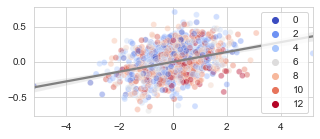

In [33]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
        
plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_acq_reg_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:09<00:00, 101.08it/s]


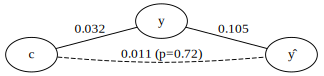

In [34]:
plot_graph(test_partially_confounded(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                    random_state=42), outfile_base='../data_out/fig/hcp_acq_reg_partial')

Permuting: 100%|██████████| 1000/1000 [00:04<00:00, 208.52it/s]


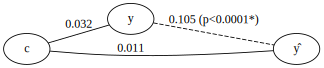

In [35]:
plot_graph(test_fully_confounded(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                random_state=42), outfile_base='../data_out/fig/hcp_acq_reg_full')

# COMBAT age group

In [36]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([df.age.astype("category").cat.codes.values[train]]).transpose()
                                  )
    
    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([df.age.astype("category").cat.codes.values[test]]).transpose()
                                  )
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.5s finished


cv: 0 {'model__alpha': 100000} -0.9300734267643159 -0.9791533004119741
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.7s finished


cv: 1 {'model__alpha': 100000} -0.9131055057865354 -1.0955185128924592
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.3s finished


cv: 2 {'model__alpha': 100000} -0.9421503042907184 -0.8421133071431012
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.9s finished


cv: 3 {'model__alpha': 100000} -0.9052915262330442 -1.0936354588406443
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.4s finished


cv: 4 {'model__alpha': 100000} -0.9358114340313147 -0.8800433698774459
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.3s finished


cv: 5 {'model__alpha': 100000} -0.9654616482430811 -0.6332270934227775
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   22.4s finished


cv: 6 {'model__alpha': 100000} -0.9226200142826692 -0.9589841130615676
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.6s finished


cv: 7 {'model__alpha': 100000} -0.9183142575876359 -1.0159642673153584
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.0s finished


cv: 8 {'model__alpha': 100000} -0.9135382705574399 -1.0449402344862762
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.5s finished


cv: 9 {'model__alpha': 100000} -0.9494178759221832 -0.7497680018493508


## Results (combat age)

*** Score on mean as model:	-1.0401469064852689
** Mean score in the inner crossvaludation (inner_cv):	-0.9295784263698937
** Mean Nested Crossvalidation Score (outer_cv):	-0.9293347659300955
Explained Variance: 0.1065350864039154
Correlation: 0.3483917910413172


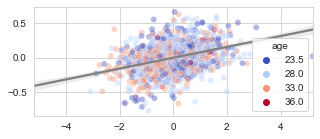

In [37]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
  
plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.age,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_age_comb_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:06<00:00, 155.57it/s]


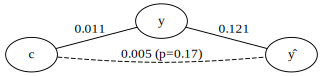

In [25]:
plot_graph(test_partially_confounded(y, predicted, df['age'], random_state=42),
          outfile_base='../data_out/fig/hcp_age_comb_partial')

Permuting: 100%|██████████| 1000/1000 [00:05<00:00, 167.39it/s]


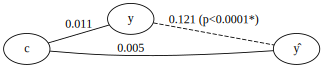

In [26]:
plot_graph(test_fully_confounded(y, predicted, df['age'], random_state=42),
          outfile_base='../data_out/fig/hcp_age_comb_full')

# COMBAT acquisition batch

In [27]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([df.Acquisition.astype("category").cat.codes.values[train]]).transpose()
                                  )
    
    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([df.Acquisition.astype("category").cat.codes.values[test]]).transpose()
                                  )
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.7s finished


cv: 0 {'model__alpha': 100000} -0.9316398231156902 -0.9849466200542856
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.3s finished


cv: 1 {'model__alpha': 100000} -0.9179827759720564 -1.0920181844748906
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.3s finished


cv: 2 {'model__alpha': 100000} -0.9458686166388022 -0.8344682629982221
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.2s finished


cv: 3 {'model__alpha': 100000} -0.9128137505056623 -1.0908273859242796
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.9s finished


cv: 4 {'model__alpha': 100000} -0.9343641987503583 -0.897486807317272
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.4s finished


cv: 5 {'model__alpha': 100000} -0.968418781274942 -0.6392219529925431
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.6s finished


cv: 6 {'model__alpha': 100000} -0.9266692657483284 -0.9543780082047694
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.2s finished


cv: 7 {'model__alpha': 100000} -0.9240174653961267 -1.0136843075560262
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.8s finished


cv: 8 {'model__alpha': 100000} -0.9214840297499312 -1.0266219728936752
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.4s finished


cv: 9 {'model__alpha': 100000} -0.9522175025691784 -0.7638490102663498


## Results (combat acquisition batch)

*** Score on mean as model:	-1.0401469064852689
** Mean score in the inner crossvaludation (inner_cv):	-0.9295784263698937
** Mean Nested Crossvalidation Score (outer_cv):	-0.9293347659300955
Explained Variance: 0.1065350864039154
Correlation: 0.3483917910413172


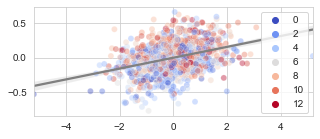

In [44]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
 
plt.figure(figsize=(5,2))

sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_acq_comb_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:10<00:00, 92.44it/s] 


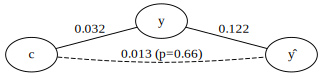

In [29]:
plot_graph(test_partially_confounded(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                    random_state=42), outfile_base='../data_out/fig/hcp_acq_comb_partial')

Permuting: 100%|██████████| 1000/1000 [00:04<00:00, 203.43it/s]


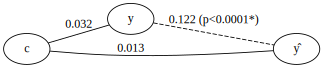

In [30]:
plot_graph(test_fully_confounded(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                random_state=42), outfile_base='../data_out/fig/hcp_acq_comb_full')

In [48]:
permutation_test(y, df.age,
                 func=lambda x, y: np.corrcoef(x, y)[1][0]**2,
                 method='approximate',
                 num_rounds=10000,
                 seed=42)

0.0014

In [56]:
def workhorse(x, y):
    df = pd.DataFrame({
        'x': x,
        'y': y
    })
    fit = ols_f('y ~ C(x)', data=df).fit()
    return fit.rsquared

permutation_test(pd.Categorical(df['Acquisition'].values).codes, y,
                 func=workhorse,
                 method='approximate',
                 num_rounds=10000,
                 seed=42)

1.0

In [ ]:
0.001